In [14]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

In [15]:
IMAGE_SIZE = 224 #Although our input images are 256 *256 we rescale them to 224*224 so we can use mobilenetv2
BATCH_SIZE = 16

# Loading the Dataset


In [16]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [17]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [18]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(16, 224, 224, 3)
[0 2 1 2 0 0 1 1 0 3 0 0 1 0 0 0]


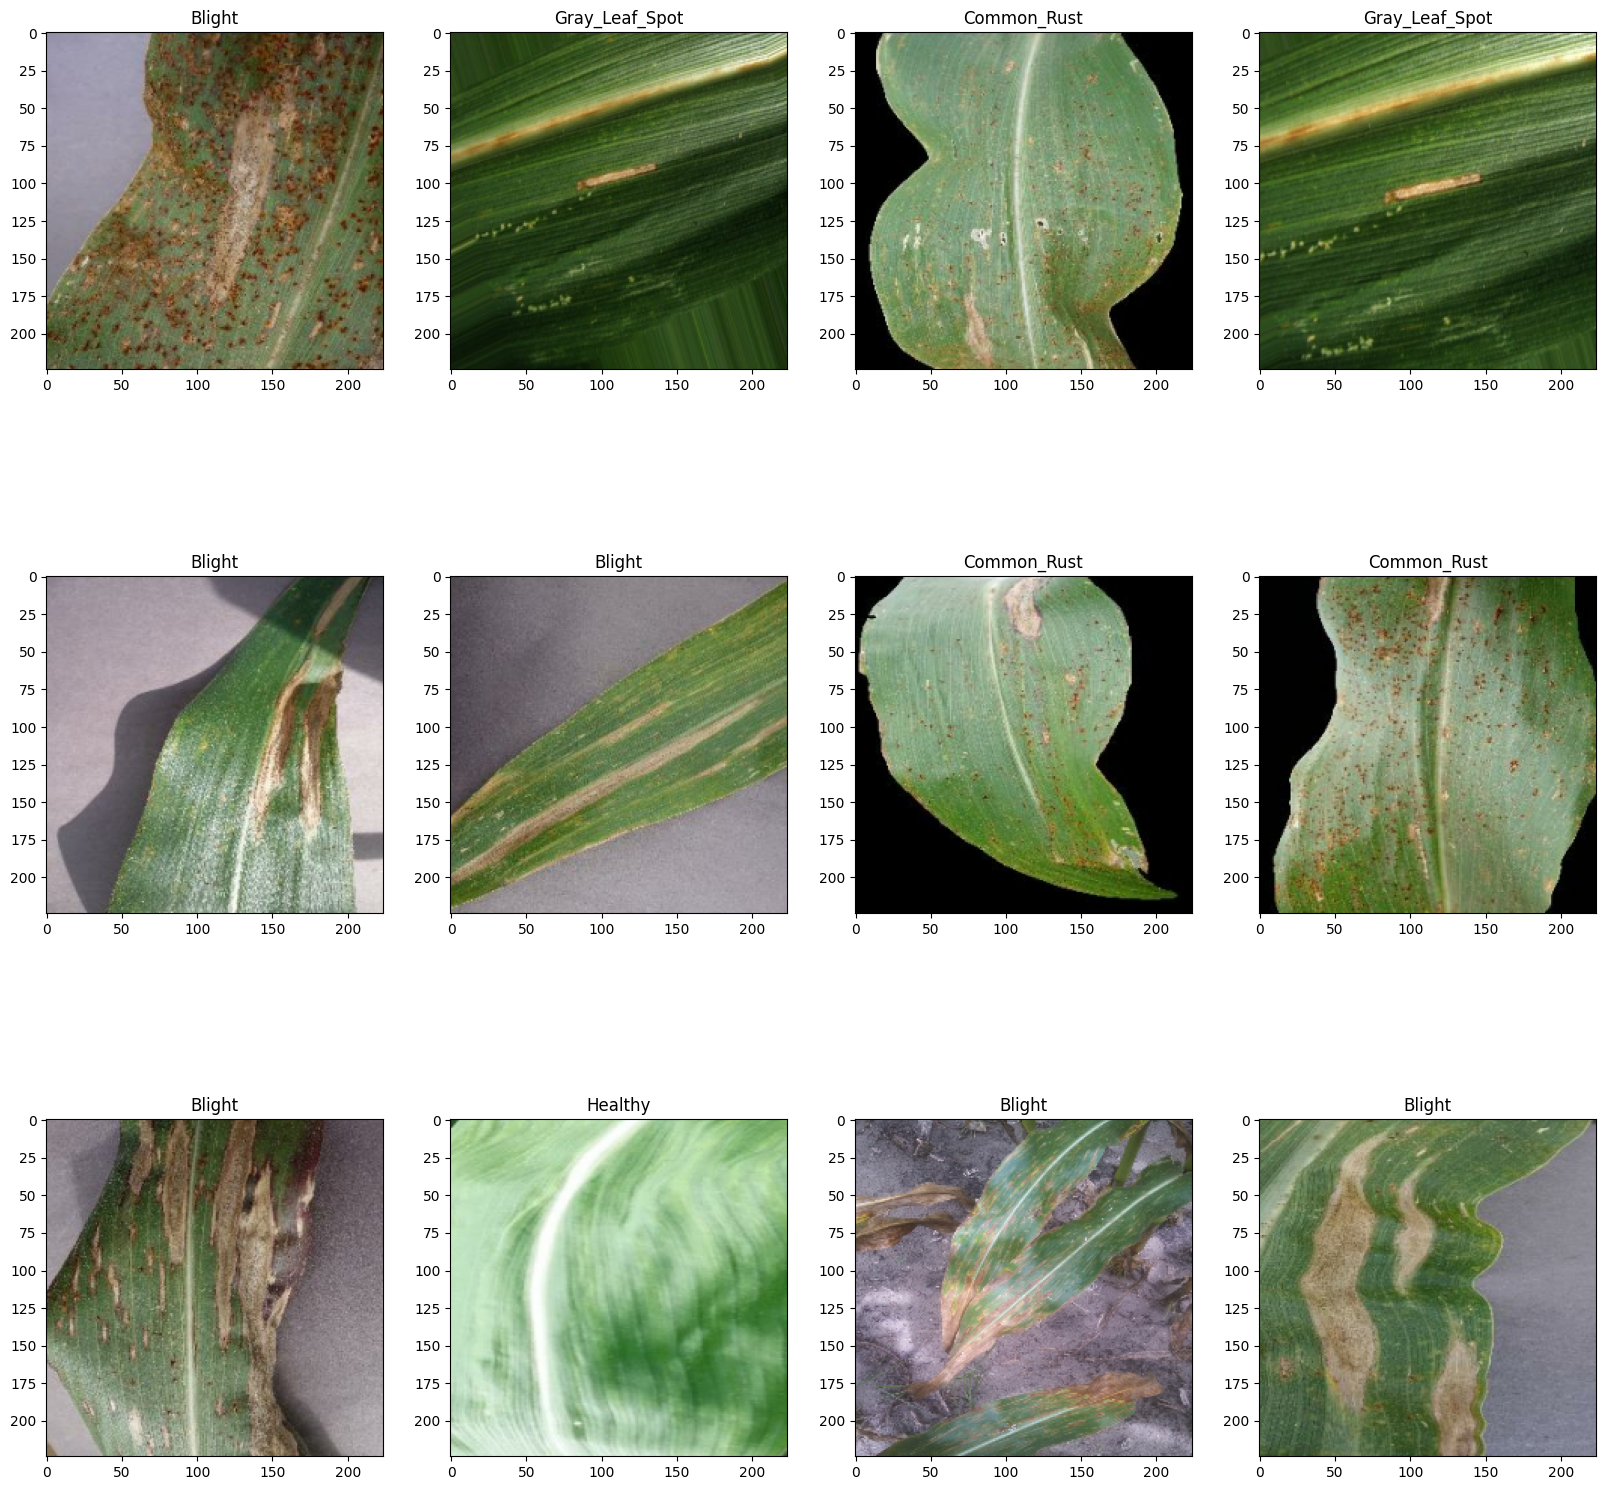

In [19]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [20]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Dataset Partition

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

240

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling and Augmentation

In [25]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])


In [26]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [29]:
IMG_SHAPE =  (224,224)+ (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [30]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [31]:
base_model.trainable = False

In [32]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [34]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax")

In [35]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [36]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [37]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

30/30 [==============================] - 11s 182ms/step - loss: 1.8067 - accuracy: 0.2021


In [38]:

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.81
initial accuracy: 0.20


In [39]:
history = model.fit(train_ds,epochs=initial_epochs,validation_data=val_ds, batch_size = 16, verbose =1)

Epoch 1/10
240/240 [==============================] - 60s 225ms/step - loss: 1.0033 - accuracy: 0.5786 - val_loss: 0.5932 - val_accuracy: 0.7896
Epoch 2/10
240/240 [==============================] - 52s 216ms/step - loss: 0.5388 - accuracy: 0.7943 - val_loss: 0.4147 - val_accuracy: 0.8292
Epoch 3/10
240/240 [==============================] - 52s 217ms/step - loss: 0.4053 - accuracy: 0.8490 - val_loss: 0.3357 - val_accuracy: 0.8708
Epoch 4/10
240/240 [==============================] - 55s 227ms/step - loss: 0.3433 - accuracy: 0.8685 - val_loss: 0.2954 - val_accuracy: 0.8792
Epoch 5/10
240/240 [==============================] - 53s 222ms/step - loss: 0.3151 - accuracy: 0.8758 - val_loss: 0.2679 - val_accuracy: 0.8979
Epoch 6/10
240/240 [==============================] - 53s 221ms/step - loss: 0.2939 - accuracy: 0.8872 - val_loss: 0.2491 - val_accuracy: 0.9125
Epoch 7/10
240/240 [==============================] - 53s 223ms/step - loss: 0.2708 - accuracy: 0.8966 - val_loss: 0.2350 - val_ac

In [40]:
base_model.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [44]:
len(model.trainable_variables)

56

In [49]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

In [50]:
history_fine = model.fit(train_ds,epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds,batch_size = 16,verbose =1)

Epoch 10/12
240/240 [==============================] - 73s 305ms/step - loss: 0.1462 - accuracy: 0.9435 - val_loss: 0.1345 - val_accuracy: 0.9458
Epoch 11/12
240/240 [==============================] - 74s 310ms/step - loss: 0.1353 - accuracy: 0.9500 - val_loss: 0.1442 - val_accuracy: 0.9500
Epoch 12/12
240/240 [==============================] - 75s 311ms/step - loss: 0.1264 - accuracy: 0.9518 - val_loss: 0.1237 - val_accuracy: 0.9521


In [51]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

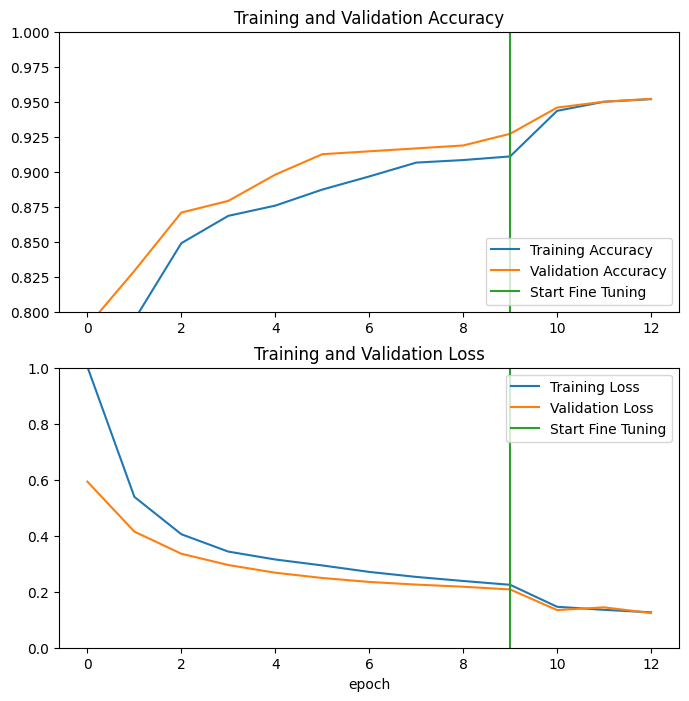

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to print
first image actual label: Gray_Leaf_Spot
1/1 [==============================] - 1s 1s/step
predicted label Gray_Leaf_Spot


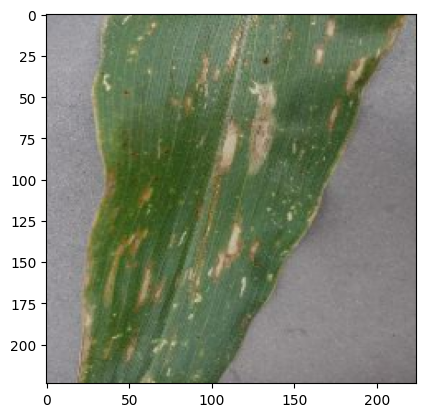

In [53]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to print")
    plt.imshow(first_image)
    print("first image actual label:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [54]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


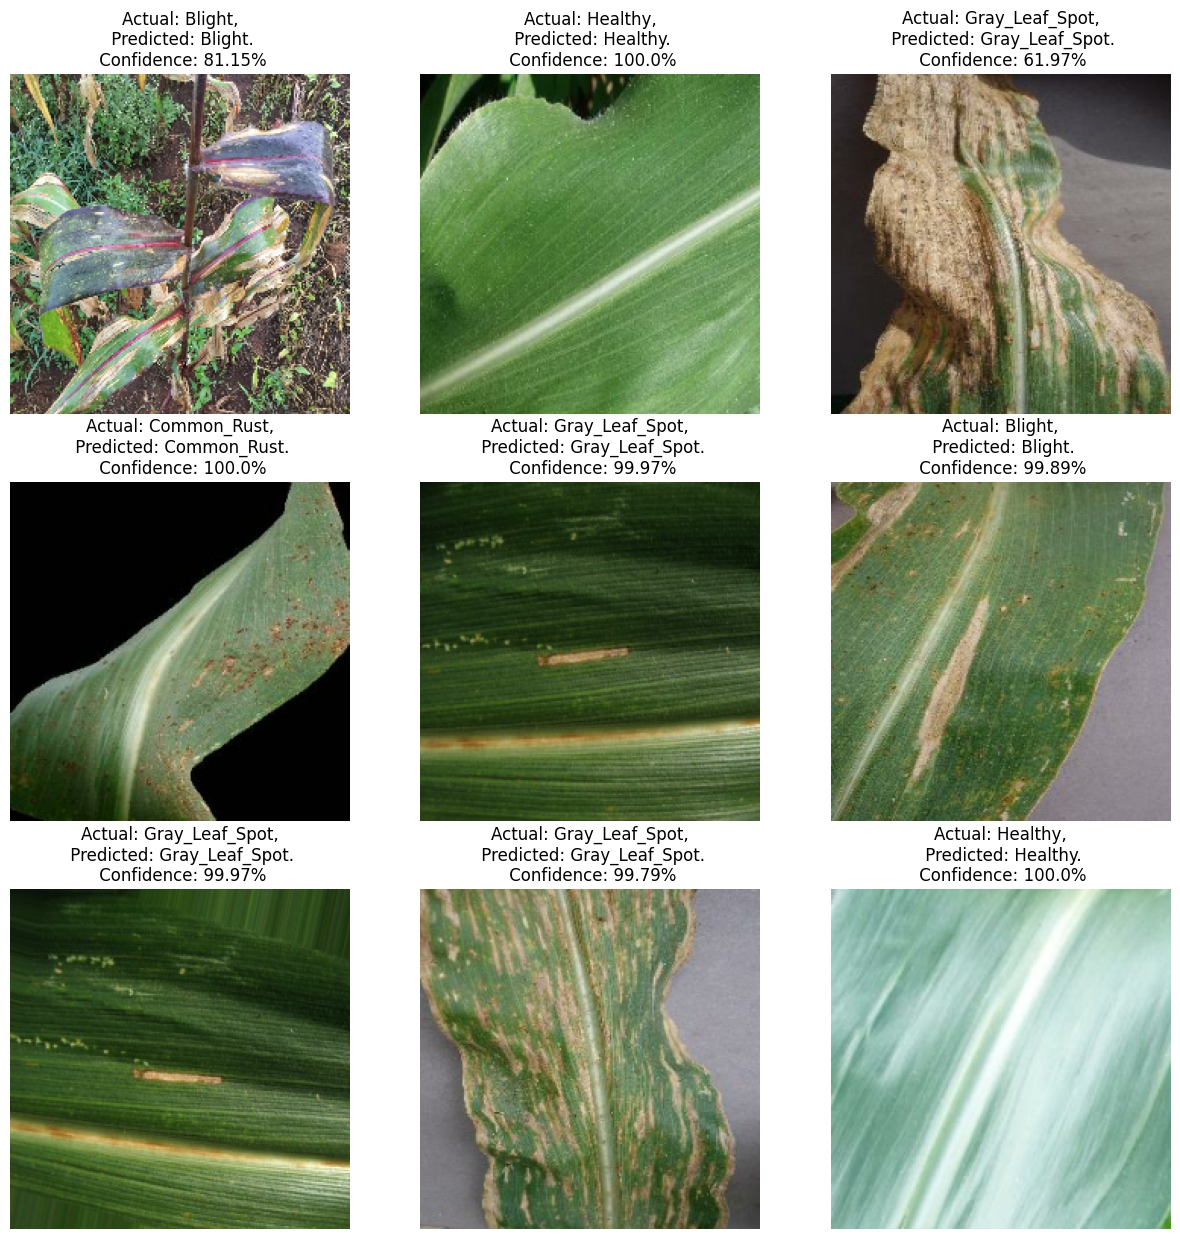

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
       
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Model Predictions

In [57]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 0s 203ms/step


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [59]:
acc = accuracy_score(y_true, y_pred)

In [60]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 95.21%


# Precision

In [61]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [62]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 95.22%


# Recall


In [63]:
recall = recall_score(y_true, y_pred, average='weighted')

In [64]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 95.21%


# F1 Score

In [65]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [66]:
print(f"f1: {f1 * 100:.2f}%")

f1: 95.18%


# Confusion Matrix

In [67]:
cm = confusion_matrix(y_true, y_pred)

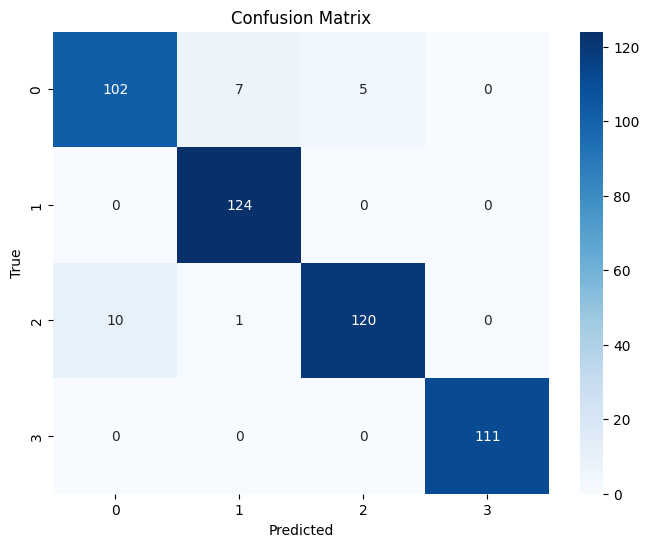

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# AUROC

In [70]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.65%


In [71]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [72]:
model_version= "MobileNet_224"
model.save(f"./models/{model_version}.keras")